# Vehicle Detection Project

### The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Define helper functions

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.feature import hog
import pickle

def convert_color(img, conv='YCrCb'):
    # Define a function to convert color space
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    if conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    if conv == 'RGB':
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vector=True):
    # Define a function to return HOG features and visualization
    # If feature_vector is True, a 1D (flattened) array is returned.
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False,
                                  visualize=vis, feature_vector=feature_vector)
        return features, hog_image
    else:
        features = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False,
                                  visualize=vis, feature_vector=feature_vector)
        return features

def bin_spatial(img, size=(16,16)):
    # Define a function to compute binned color features
    return cv2.resize(img, size).ravel()

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Define a function to compute color histogram features
    channel1 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1[0], channel2[0], channel3[0]))
    return hist_features


def extract_features(imgs, color_space='BGR', spatial_size=(16, 16),
                     hist_bins=128, orient=9, pix_per_cell=8,
                     cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for img in imgs:
        img_features = []
        image = cv2.imread(img)
        if color_space != 'BGR':
            feature_image = convert_color(image, color_space)
        else:
            feature_image = np.copy(image)

        if spatial_feat:
            spatial_feature = bin_spatial(feature_image, spatial_size)
            img_features.append(spatial_feature)
        if hist_feat:
            hist_feature = color_hist(feature_image, hist_bins)
            img_features.append(hist_feature)
        if hog_feat:
            if hog_channel == 'ALL':
                hog_ch1 = get_hog_features(feature_image[:,:,0], orient,
                              pix_per_cell, cell_per_block, vis=False, feature_vector=True)
                hog_ch2 = get_hog_features(feature_image[:,:,1], orient,
                              pix_per_cell, cell_per_block, vis=False, feature_vector=True)
                hog_ch3 = get_hog_features(feature_image[:,:,2], orient,
                              pix_per_cell, cell_per_block, vis=False, feature_vector=True)
                hog_feature = np.concatenate((hog_ch1, hog_ch2, hog_ch3))
            else:
                hog_feature = get_hog_features(feature_image[:,:,hog_channel], orient,
                              pix_per_cell, cell_per_block, vis=False, feature_vector=True)
            img_features.append(hog_feature)
        features.append(np.concatenate(img_features))
    return features

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    for bbox in bboxes:
        top_left = bbox[0]
        bottom_right = bbox[1]
        cv2.rectangle(imcopy, (top_left[0], top_left[1]), (bottom_right[0], bottom_right[1]), color, thick)
    return imcopy

### Extract data

In [2]:
import glob
notcars = list(glob.glob('data/non-vehicle/*.png'))
cars = list(glob.glob('data/vehicle/**/*.png'))
#print(len(notcars))
#print(len(cars))

### train a Linear SVM classifier

In [3]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

orient = 12
pix_per_cell = 8
cell_per_block = 2
spatial_size = (16, 16)
hist_bins = 128
color_space = 'YCrCb'

# Extract features from image dataset
car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size,
                     hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                     cell_per_block=cell_per_block, hog_channel='ALL',
                     spatial_feat=True, hist_feat=True, hog_feat=True)
noncar_features = extract_features(notcars, color_space=color_space, spatial_size=spatial_size,
                     hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                     cell_per_block=cell_per_block, hog_channel='ALL',
                     spatial_feat=True, hist_feat=True, hog_feat=True)



# Create an array stack of feature vectors
# NOTE: StandardScaler() expects np.float64
X = np.vstack((car_features, noncar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

# Split up data into randomized training and test sets
# It's important to do the scaling after splitting the data, otherwise you are 
# allowing the scaler to peer into your test data!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Normalize data
# Fit a per-column scaler
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)

# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

# Use a linear SVC
svc = LinearSVC()
svc.fit(X_train, y_train)

print('Test Accuracy of SVC = ', svc.score(X_test, y_test))

data_pickle = {
    "svc" : svc,
    "scaler" : X_scaler,
    "orient" : orient,
    "pix_per_cell" : pix_per_cell,
    "cell_per_block" : cell_per_block,
    "spatial_size" : spatial_size,
    "hist_bins" : hist_bins,
    "color_space" : color_space,
}

filename = "svc_pickle.p"
with open(filename, 'wb') as f:
    pickle.dump(data_pickle, f)
    print("data saved to svc_pickle.p")

Test Accuracy of SVC =  0.9938063063063063
data saved to svc_pickle.p


### Implement a sliding-window technique

In [10]:
def find_cars(img, ystart, ystop, color_space, scale, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins):
    draw_img = np.copy(img)
    # img = img.astype(np.float32) / 255
    
    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    if scale != 1:
        image_shape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(image_shape[1]/scale), np.int(image_shape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Compute individual channel HOG features for the entire image
    # hog dimension = (nyblocks x nxblocks x cell_per_block x cell_per_block x orient)
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vector=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vector=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vector=False)
    
    x_nblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    y_nblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    
    window_size = 64   # pixels
    block_per_window = (window_size // pix_per_cell) - cell_per_block + 1
    '''
    if scale > 1:
        cells_per_step = 2
    else:
        cells_per_step = 1
    '''
    cells_per_step = 2
    nx_step = 1 + (x_nblocks - block_per_window) // cells_per_step
    ny_step = 1 + (y_nblocks - block_per_window) // cells_per_step

    car_windows = []
    
    for yb in range(ny_step):
        for xb in range(nx_step):
            xpos = xb * cells_per_step
            ypos = yb * cells_per_step
            
            hog_feature1 = hog1[ypos:ypos+block_per_window, xpos:xpos+block_per_window].ravel()
            hog_feature2 = hog2[ypos:ypos+block_per_window, xpos:xpos+block_per_window].ravel()
            hog_feature3 = hog3[ypos:ypos+block_per_window, xpos:xpos+block_per_window].ravel()
            hog_feature = np.concatenate((hog_feature1, hog_feature2, hog_feature3))
            # Extract the image patch
            x_top_left = xpos * pix_per_cell   # convert cell to pixel
            y_top_left = ypos * pix_per_cell
            subimg = cv2.resize(ctrans_tosearch[y_top_left:y_top_left+window_size, x_top_left:x_top_left+window_size], (64,64))
            
            # Get color feature
            spatial_feature = bin_spatial(subimg, size=spatial_size)
            hist_feature = color_hist(subimg, nbins=hist_bins)
            
            # concatenate all features
            features = np.hstack((spatial_feature, hist_feature, hog_feature)).reshape(1, -1)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(features)
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(x_top_left * scale)
                ybox_left = np.int(y_top_left * scale)
                window = np.int(window_size * scale)
                car_windows.append(((xbox_left, ybox_left+ystart), (xbox_left+window, ybox_left+ystart+window)))
                cv2.rectangle(draw_img, (xbox_left, ybox_left+ystart), (xbox_left+window, ybox_left+ystart+window), (0,0,255), 6)
            
    # print(car_windows)
    return car_windows

### Test the pipeline on image

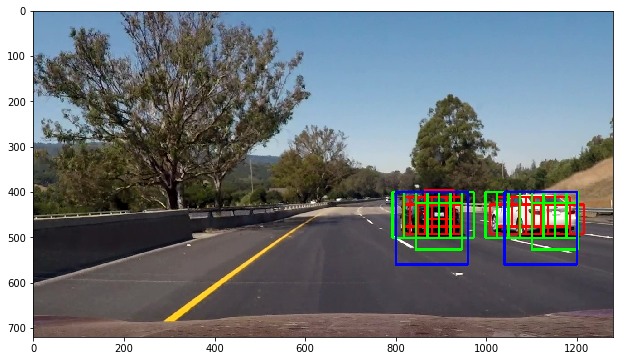

In [30]:
# load a pe-trained svc model from a serialized (pickle) file
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )

# get attributes of our svc object
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
color_space = dist_pickle["color_space"]
ystart = 400
ystop = 656
scale = 1.5

# ystart, ystop, scale, overlap, color
searches = [
    (380, 500, 1.0, (0, 0, 255)),  # 64x64
    (400, 550, 1.6, (0, 255, 0)),  # 101x101
    (400, 680, 2.5, (255, 0, 0)),  # 161x161
    (400, 680, 3.8, (255, 255, 0)), # 256x256
]
bbox_list = []

filename = 'test_images/scene00006.jpg'
img = cv2.imread(filename)
draw_img = np.copy(img)
for ystart, ystop, scale, color in searches:
    bboxes = find_cars(img, ystart, ystop, color_space, scale, svc, X_scaler, orient, 
                       pix_per_cell, cell_per_block, spatial_size, hist_bins)
    if len(bboxes) > 0:
        bbox_list.append(bboxes)
    draw_img = draw_boxes(draw_img, bboxes, color=color, thick=3)
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
#plt.savefig('./output_images/result4.jpg')
plt.show()

### Build a heat-map and remove false positives

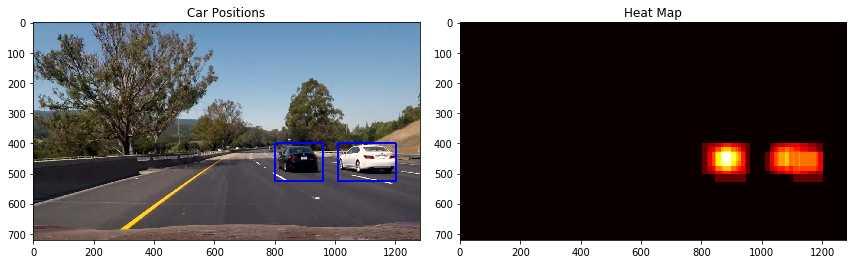

In [32]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    for search in bbox_list:
        for box in search:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    labeled_array, num_features = labels
    for car_number in range(1, num_features+1):
        # Find pixels with each car_number label value
        # .nonzero(): Return the indices of the elements that are non-zero
        nonzero = (labeled_array == car_number).nonzero()
        # Identify x and y values of those pixels
        y = np.array(nonzero[0])
        x = np.array(nonzero[1]) 
        bbox = ((np.min(x), np.min(y)), (np.max(x), np.max(y)))
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    return img

# ystart, ystop, scale, overlap, color
searches = [
    (380, 500, 1.0, (0, 0, 255)),  # 64x64
    (400, 550, 1.6, (0, 255, 0)),  # 101x101
    (400, 680, 2.5, (255, 0, 0)),  # 161x161
    (400, 680, 3.8, (255, 255, 0)), # 256x256
]

filename = 'test_images/scene00006.jpg'
img = cv2.imread(filename)

total_boxes = []
for ystart, ystop, scale, color in searches:
    bboxes = find_cars(img, ystart, ystop, color_space, scale, svc, X_scaler, orient, 
                       pix_per_cell, cell_per_block, spatial_size, hist_bins)
    total_boxes.append(bboxes)

heat = np.zeros_like(img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, total_boxes)

# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying
# np.clip : Clip (limit) the values in an array.
#           Given an interval, values outside the interval are clipped to the interval edges.
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)

draw = draw_labeled_bboxes(img, labels)

fig = plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(cv2.cvtColor(draw, cv2.COLOR_BGR2RGB))
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()

In [57]:
from collections import deque
frames = deque([], 3)

def vehicle_detection_pipeline(img):
    # ystart, ystop, scale, overlap, color
    searches = [
        (380, 480, 1.0, (0, 0, 255)),  # 64x64
        (390, 550, 1.6, (0, 255, 0)),  # 101x101
        (400, 610, 2.5, (255, 0, 0)),  # 161x161
        (400, 680, 3.8, (255, 255, 0)), # 256x256
    ]

    total_boxes = []
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    for ystart, ystop, scale, color in searches:
        bboxes = find_cars(img, ystart, ystop, color_space, scale, svc, X_scaler, orient, 
                           pix_per_cell, cell_per_block, spatial_size, hist_bins)
        total_boxes.append(bboxes)
    
    if len(frames) == 0:
        all_frames_heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    else:
        all_frames_heatmap = frames[-1]

    current__frame_heat = np.zeros_like(img[:,:,0]).astype(np.float)
    if len(total_boxes) > 0:
        current_heatmap = add_heat(current__frame_heat, total_boxes)

    if len(frames) == 3:
        all_frames_heatmap -= frames[0] * 0.3**5

    all_frames_heatmap = all_frames_heatmap*0.8 + current__frame_heat

    frames.append(all_frames_heatmap)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(all_frames_heatmap, len(frames))
    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw = draw_labeled_bboxes(img, labels)
    # convert BGR to RGB image
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    return draw

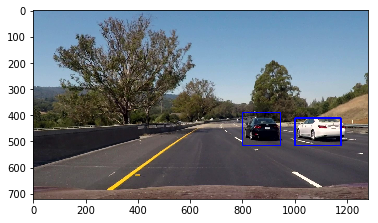

In [60]:
image = mpimg.imread('test_images/scene00003.jpg')
plt.imshow(vehicle_detection_pipeline(image))
plt.savefig('./output_images/final_output.jpg')

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# run image pipeline with video
output = 'test_video_result.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(vehicle_detection_pipeline)  #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_video_result.mp4
[MoviePy] Writing video test_video_result.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:41<00:01,  1.08s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_result.mp4 

Wall time: 42.9 s


In [8]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(output))

In [9]:
# run image pipeline with video
frames = deque([], 4)
output = 'p_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(vehicle_detection_pipeline)  #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video p_video_result.mp4
[MoviePy] Writing video p_video_result.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [28:27<00:01,  1.34s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: p_video_result.mp4 

Wall time: 28min 28s


In [20]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(output))